# Data Source
ชุดข้อมูลนี้ได้มาจากเว็บไซต์ https://share.traffy.in.th/teamchadchart# โดยจะเป็นชุดข้อมูลเกี่ยวกับภาพปัญหาการจราจร

In [1]:
import pandas as pd
import numpy as np
from collections import Counter

import requests
from PIL import Image
from io import BytesIO

import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
plt.rcParams['font.family'] = 'tahoma'

ตัวอย่างข้อมูลและรูปแบบของ DataFrame

In [3]:
df = pd.read_csv('teamchadchart.csv')
df.head(5)

,type,organization,comment,coords,photo,address,district,subdistrict,province,timestamp
0,อื่นๆ,เพื่อนชัชชาติ,ความปลอดภัย,"[100.468087,13.712739]",https://storage.googleapis.com/traffy_public_b...,70/9 ซ. กัลปพฤกษ์ แขวง บางค้อ เขตจอมทอง กรุงเท...,จอมทอง,บางค้อ,กรุงเทพมหานคร,2022-03-21 03:42:49.662167+00
1,น้ำท่วม,เพื่อนชัชชาติ,น้ำท่วมในซอยประชาราษฎร์บำเพ็ญ 20 มาหลายปีแล้ว ...,"[100.582624201267,13.7747861954847]",https://storage.googleapis.com/traffy_public_b...,2/41 ซอย ประชาราษฎร์บำเพ็ญ 20 แขวง สามเสนนอก เ...,ห้วยขวาง,ห้วยขวาง,กรุงเทพมหานคร,2022-03-20 15:46:49.254093+00
2,อื่นๆ,เพื่อนชัชชาติ,น้ำท่วม,"[100.582624201267,13.7747861954847]",https://storage.googleapis.com/traffy_public_b...,2/41 ซอย ประชาราษฎร์บำเพ็ญ 20 แขวง สามเสนนอก เ...,ห้วยขวาง,ห้วยขวาง,กรุงเทพมหานคร,2022-03-20 15:43:01.546614+00
3,น้ำท่วม,เพื่อนชัชชาติ,น้ำท่วมขัง เส้นประชาราษฎร์บำเพ็ญ ห้วยขวาง,"[100.579496,13.776825]",https://storage.googleapis.com/traffy_public_b...,238/3 ถนนรัชดาภิเษก แขวงห้วยขวาง เขตห้วยขวาง ก...,ห้วยขวาง,ห้วยขวาง,กรุงเทพมหานคร,2022-03-20 10:09:02.354578+00
4,อื่นๆ,เพื่อนชัชชาติ,อยากทำหมันแมว,"[100.798616542995,13.8498441666148]",https://storage.googleapis.com/traffy_public_b...,2058 ถนน ประชาร่วมใจ แขวง ทรายกองดินใต้ เขตคลอ...,คลองสามวา,ทรายกองดินใต้,กรุงเทพมหานคร,2022-03-20 01:49:20.041482+00


# Exploratory Data Analysis
สำรวจดูข้อมูลในชุดข้อมูลนี้และวิเคราะห์เพื่อตัดสินใจในการทำ Data Cleaning และ Feature Engineering กับข้อมูลให้เหมาะสม

สำหรับงาน Image Classification นี้ ต้องการใช้เพียงรูปของ น้ำท่วม, จราจร, ทางเท้า, ความปลอดภัย, ขยะ <br>
ดังนั้นจึงลบรูปประเภท อื่นๆ และ เสนอแนะ ออกจากชุดข้อมูล

In [4]:
df.type.unique()

array(['อื่นๆ', 'น้ำท่วม', 'เสนอแนะ', 'ทางเท้า', 'จราจร', 'ขยะ',
       'ความปลอดภัย'], dtype=object)

ชุดข้อมูลที่เหลือเพียงรูปในประเภทที่ต้องการใช้งาน

In [5]:
df = df.drop(df.loc[df['type']=='อื่นๆ'].index)
df = df.drop(df.loc[df['type']=='เสนอแนะ'].index)
df = df.reset_index(drop=True)
df

,type,organization,comment,coords,photo,address,district,subdistrict,province,timestamp
0,น้ำท่วม,เพื่อนชัชชาติ,น้ำท่วมในซอยประชาราษฎร์บำเพ็ญ 20 มาหลายปีแล้ว ...,"[100.582624201267,13.7747861954847]",https://storage.googleapis.com/traffy_public_b...,2/41 ซอย ประชาราษฎร์บำเพ็ญ 20 แขวง สามเสนนอก เ...,ห้วยขวาง,ห้วยขวาง,กรุงเทพมหานคร,2022-03-20 15:46:49.254093+00
1,น้ำท่วม,เพื่อนชัชชาติ,น้ำท่วมขัง เส้นประชาราษฎร์บำเพ็ญ ห้วยขวาง,"[100.579496,13.776825]",https://storage.googleapis.com/traffy_public_b...,238/3 ถนนรัชดาภิเษก แขวงห้วยขวาง เขตห้วยขวาง ก...,ห้วยขวาง,ห้วยขวาง,กรุงเทพมหานคร,2022-03-20 10:09:02.354578+00
2,ทางเท้า,เพื่อนชัชชาติ,สงสัยค่ะ การจอดรถบนฟุตบาทคือผิด ประชาชนร้องเรี...,"[100.559517592192,13.7700838665743]",https://storage.googleapis.com/traffy_public_b...,ตรงข้ามโรงเรียนพร้อมพรรณ แขวง ดินแดง เขตดินแดง...,ดินแดง,ดินแดง,กรุงเทพมหานคร,2022-03-17 14:12:52.56103+00
3,ทางเท้า,เพื่อนชัชชาติ,สงสัยค่ะ การจอดรถบนฟุตบาทคือผิด ประชาชนร้องเรี...,"[100.559512898326,13.7700848434939]",https://storage.googleapis.com/traffy_public_b...,ตรงข้ามโรงเรียนพร้อมพรรณ แขวง ดินแดง เขตดินแดง...,ดินแดง,ดินแดง,กรุงเทพมหานคร,2022-03-17 13:44:37.242707+00
4,ทางเท้า,เพื่อนชัชชาติ,สวัสดีครับ ขอแจ้งเรื่องร้องทุกข์ชาวบ้านเดือนร้...,"[100.474905,13.712991]",https://storage.googleapis.com/traffy_public_b...,789 ถนน ราชพฤกษ์ แขวง ตลาดพลู เขตธนบุรี กรุงเท...,จอมทอง,บางค้อ,กรุงเทพมหานคร,2022-03-15 13:36:10.447933+00
...,...,...,...,...,...,...,...,...,...,...
833,น้ำท่วม,เพื่อนชัชชาติ,NaN,"[100.542044773125,13.7107793363401]",https://storage.googleapis.com/traffy_public_b...,ถนนเย็นอากาศ สาทร,ยานนาวา,ช่องนนทรี,กรุงเทพมหานคร,2021-09-01 09:33:34.304352+00
834,น้ำท่วม,เพื่อนชัชชาติ,NaN,"[100.550893121724,13.7886542313931]",https://storage.googleapis.com/traffy_public_b...,ถนนจันทน์ สาทร,พญาไท,สามเสนใน,กรุงเทพมหานคร,2021-09-01 09:33:32.434846+00
835,น้ำท่วม,เพื่อนชัชชาติ,NaN,"[100.623943681791,13.9434269410406]",https://storage.googleapis.com/traffy_public_b...,รพ.บีแคร์ สายไหม,สายไหม,สายไหม,กรุงเทพมหานคร,2021-09-01 09:33:30.677133+00
836,น้ำท่วม,เพื่อนชัชชาติ,NaN,"[100.475121821806,13.6999172528007]",https://storage.googleapis.com/traffy_public_b...,หมู่บ้านเชาวลิตค่ะ ซอยจอมทอง 12 แขวงบางค้อ เขต...,จอมทอง,บางค้อ,กรุงเทพมหานคร,2021-09-01 09:33:28.964543+00


ทดสอบเรียกดูรูปภาพ

In [6]:
img_list = []
label_list = []

for images, labels in df[['photo', 'type']][:9].values:
    response = requests.get(images)
    img = Image.open(BytesIO(response.content))
    img_list.append(img)
    label_list.append(labels)

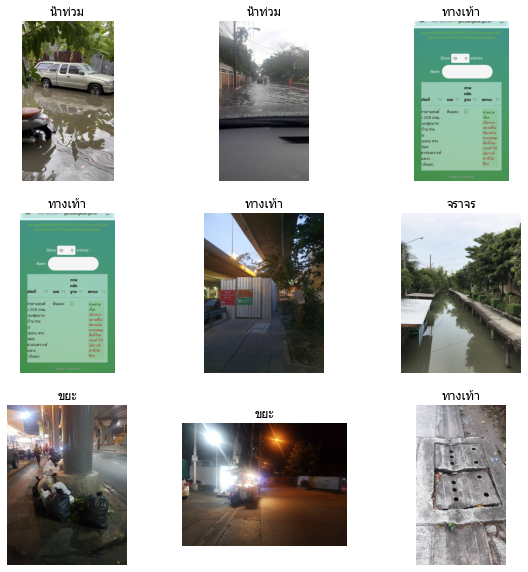

In [42]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img_list[i])
    plt.title(label_list[i])
    plt.axis("off")

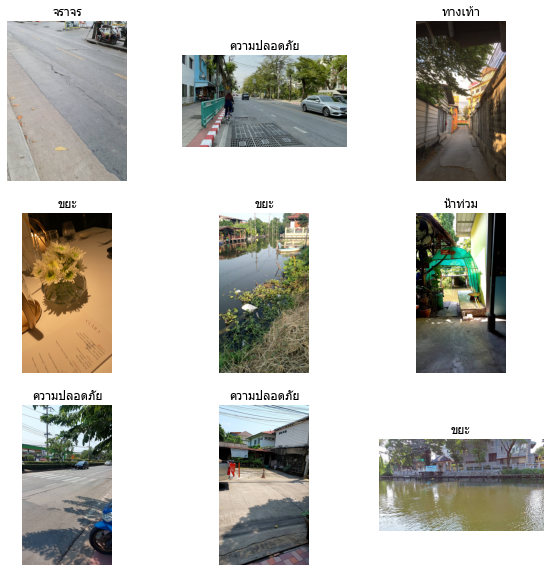

In [46]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img_list[i])
    plt.title(label_list[i])
    plt.axis("off")

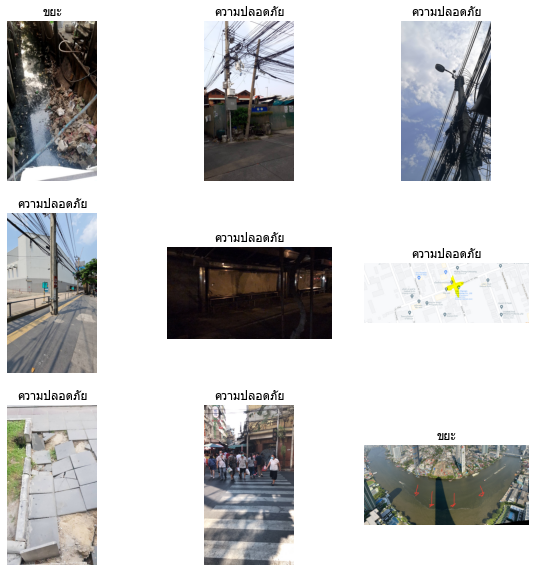

In [48]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img_list[i])
    plt.title(label_list[i])
    plt.axis("off")

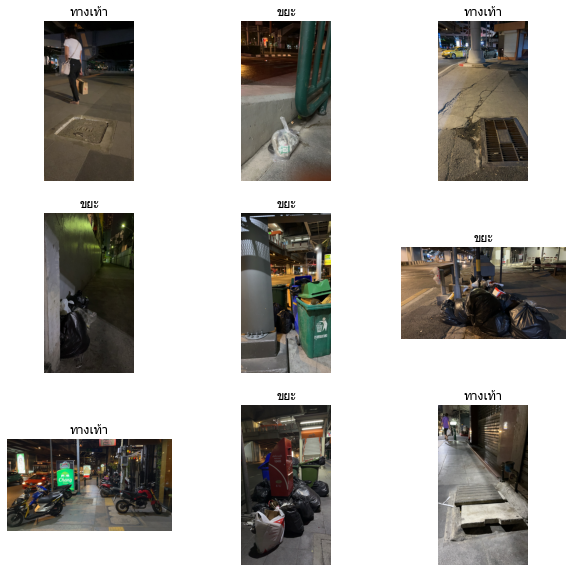

In [51]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img_list[i])
    plt.title(label_list[i])
    plt.axis("off")

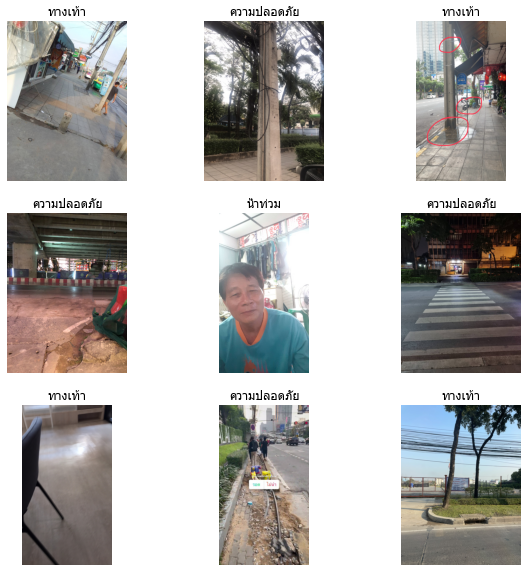

In [53]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img_list[i])
    plt.title(label_list[i])
    plt.axis("off")

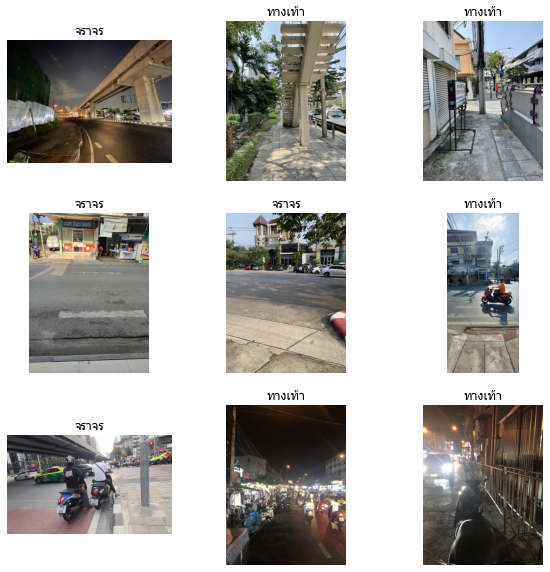

In [55]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img_list[i])
    plt.title(label_list[i])
    plt.axis("off")

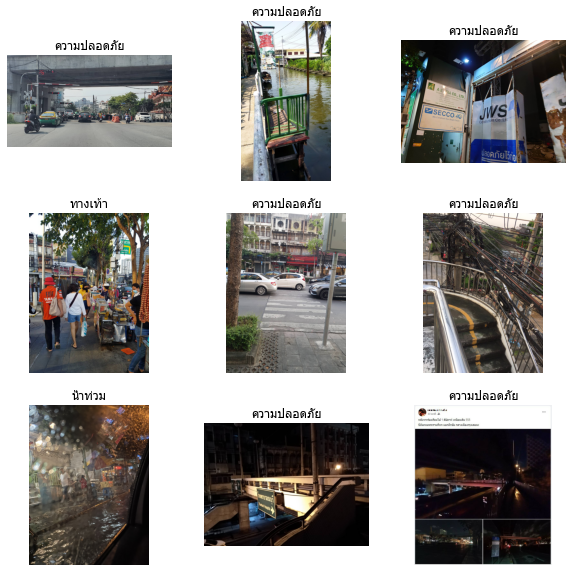

In [57]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img_list[i])
    plt.title(label_list[i])
    plt.axis("off")

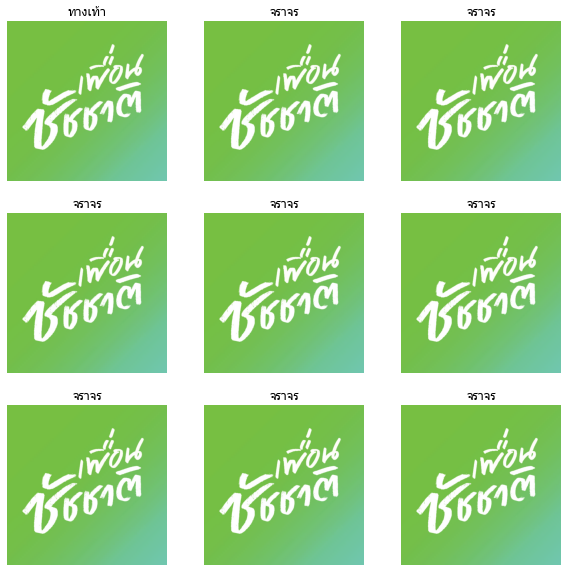

In [59]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img_list[i])
    plt.title(label_list[i])
    plt.axis("off")

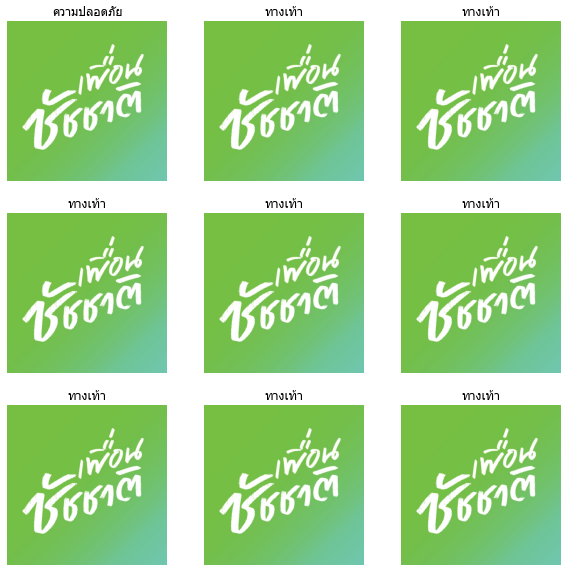

In [61]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img_list[i])
    plt.title(label_list[i])
    plt.axis("off")

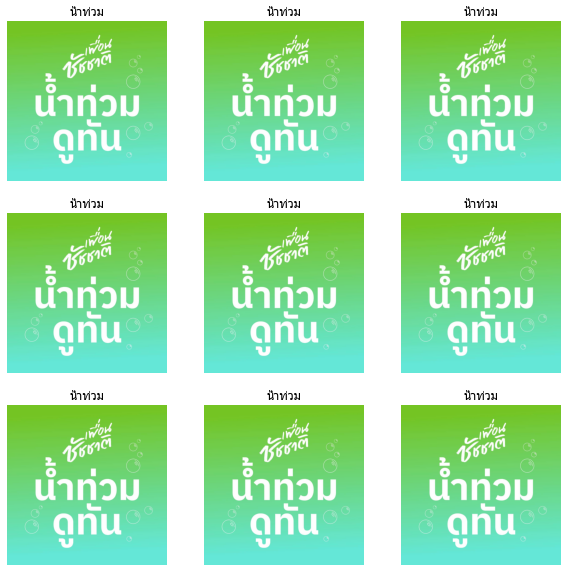

In [8]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img_list[i])
    plt.title(label_list[i])
    plt.axis("off")

จะพบว่ามีหลายรูปภาพที่ไม่ใช่รูปปัญหาจริง และมีรูปภาพที่ Label ผิดประเภทรวมอยู่ด้วย

## หาลักษณะเฉพาะของรูปเพื่อนชัชชาติ เพื่อนำไปทำ Data Cleaning ในขั้นตอนถัดไป

ตัวอย่างรูปเพื่อนชัชชาติน้ำท่วมดูทัน และ RGB Color 100 ค่าแรกของรูปเพื่อนชัชชาติน้ำท่วมดูทัน

In [6]:
response = requests.get(df.photo[835])
img = Image.open(BytesIO(response.content))
img = img.convert("RGB")
color = list(img.getdata())

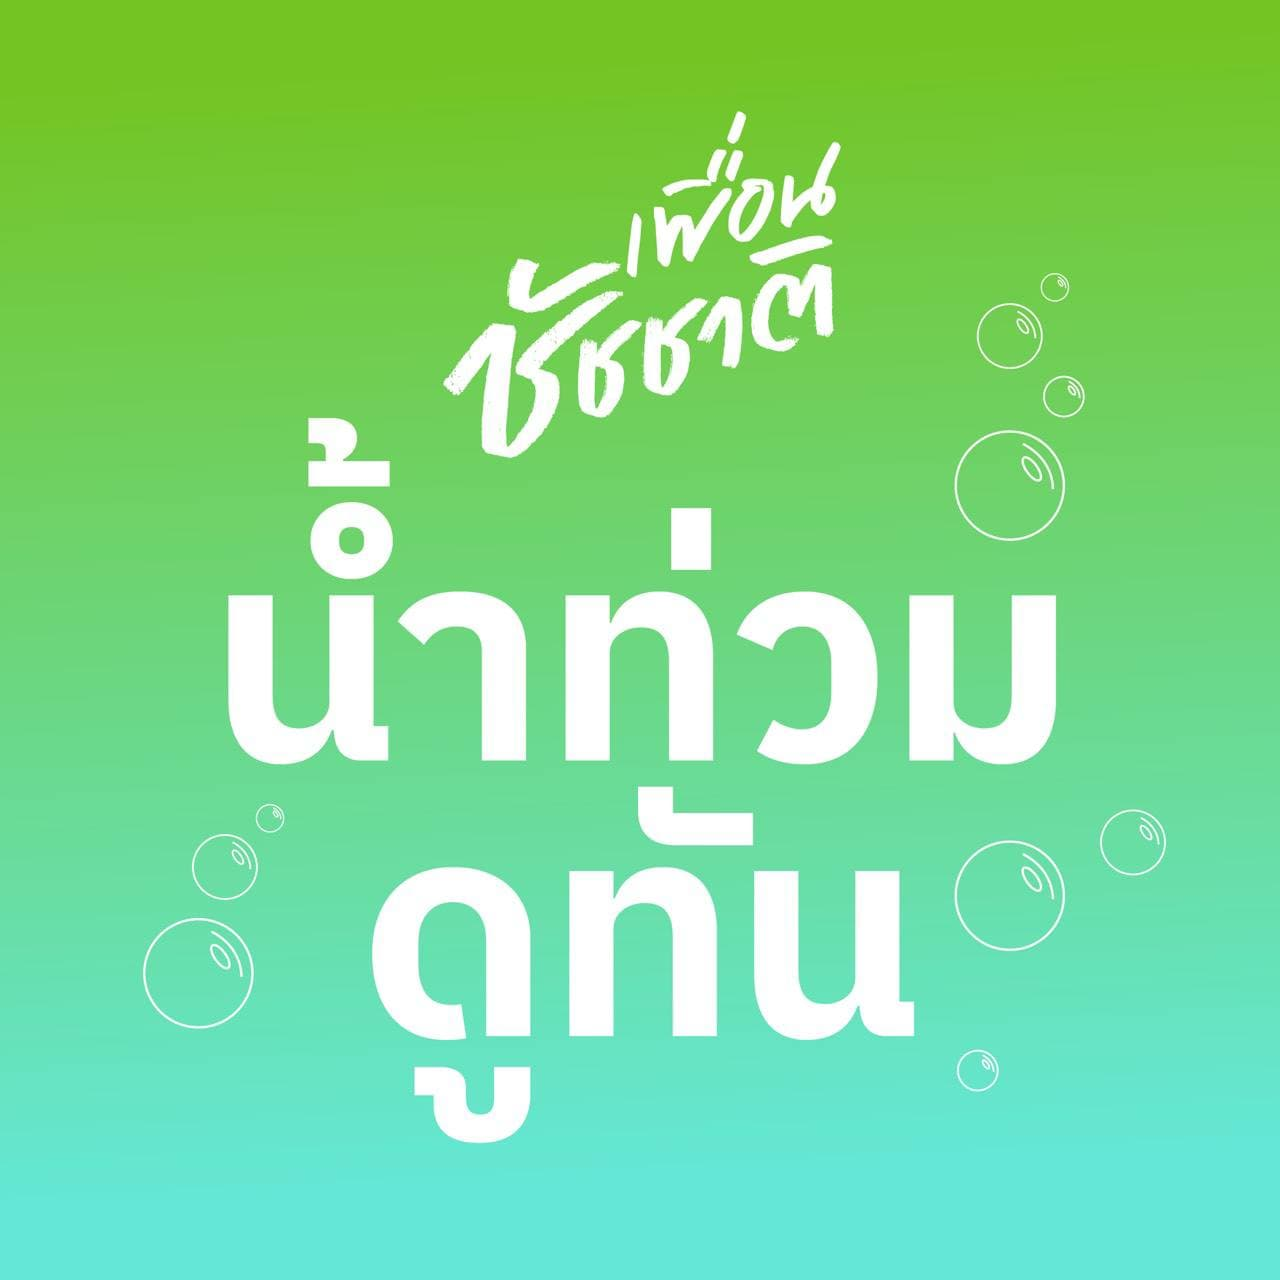

In [7]:
img

In [8]:
print(color[:100])

[(116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 196, 35), (116, 1

ตัวอย่างรูปเพื่อนชัชชาติ และ RGB Color 100 ค่าแรกของรูปเพื่อนชัชชาติ

In [9]:
response = requests.get(df.photo[330])
img = Image.open(BytesIO(response.content))
img = img.convert("RGB")
color = list(img.getdata())

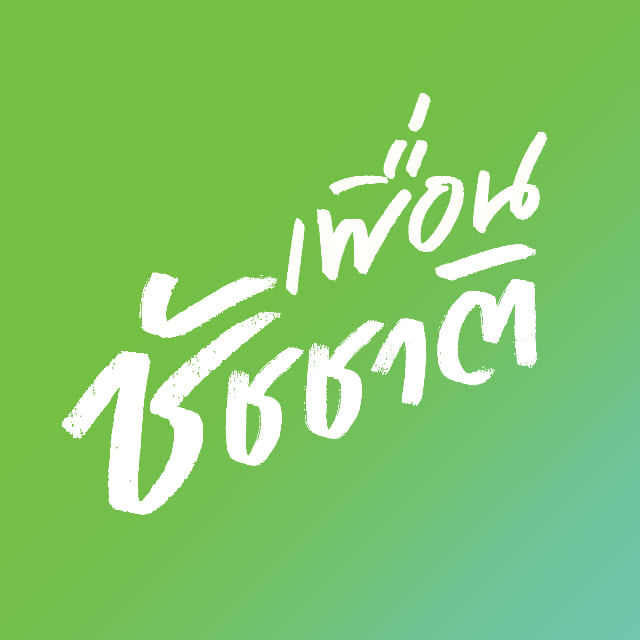

In [10]:
img

In [11]:
print(color[:100])

[(119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 191, 66), (119, 1

# Data Cleaning and Preparation

ค้นหารูปที่มีค่า RGB 100 ค่าแรกตรงกับ ค่า RGB ของรูปเพื่อนชัชชาติ และเพื่อนชัชชาติน้ำท่วมดูทัน <br>
จากนั้นจึงเก็บ Index ว่ารูปนั้น ๆ อยู่แถวที่เท่าไหร่ในชุดข้อมูล

In [12]:
idx_list = []

for i in range(df.shape[0]):
    response = requests.get(df.photo[i])
    img = Image.open(BytesIO(response.content))
    img = img.convert("RGB")
    color = list(img.getdata())
    for j in range(100):
        if (119, 191, 66) == color[j]:
            idx_list.append(i)
        elif (116, 196, 35) == color[j]:
            idx_list.append(i)
    print(f"Done Image {i}")

Done Image 0
Done Image 1
Done Image 2
Done Image 3
Done Image 4
Done Image 5
Done Image 6
Done Image 7
Done Image 8
Done Image 9
Done Image 10
Done Image 11
Done Image 12
Done Image 13
Done Image 14
Done Image 15
Done Image 16
Done Image 17
Done Image 18
Done Image 19
Done Image 20
Done Image 21
Done Image 22
Done Image 23
Done Image 24
Done Image 25
Done Image 26
Done Image 27
Done Image 28
Done Image 29
Done Image 30
Done Image 31
Done Image 32
Done Image 33
Done Image 34
Done Image 35
Done Image 36
Done Image 37
Done Image 38
Done Image 39
Done Image 40
Done Image 41
Done Image 42
Done Image 43
Done Image 44
Done Image 45
Done Image 46
Done Image 47
Done Image 48
Done Image 49
Done Image 50
Done Image 51
Done Image 52
Done Image 53
Done Image 54
Done Image 55
Done Image 56
Done Image 57
Done Image 58
Done Image 59
Done Image 60
Done Image 61
Done Image 62
Done Image 63
Done Image 64
Done Image 65
Done Image 66
Done Image 67
Done Image 68
Done Image 69
Done Image 70
Done Image 71
Do

Done Image 554
Done Image 555
Done Image 556
Done Image 557
Done Image 558
Done Image 559
Done Image 560
Done Image 561
Done Image 562
Done Image 563
Done Image 564
Done Image 565
Done Image 566
Done Image 567
Done Image 568
Done Image 569
Done Image 570
Done Image 571
Done Image 572
Done Image 573
Done Image 574
Done Image 575
Done Image 576
Done Image 577
Done Image 578
Done Image 579
Done Image 580
Done Image 581
Done Image 582
Done Image 583
Done Image 584
Done Image 585
Done Image 586
Done Image 587
Done Image 588
Done Image 589
Done Image 590
Done Image 591
Done Image 592
Done Image 593
Done Image 594
Done Image 595
Done Image 596
Done Image 597
Done Image 598
Done Image 599
Done Image 600
Done Image 601
Done Image 602
Done Image 603
Done Image 604
Done Image 605
Done Image 606
Done Image 607
Done Image 608
Done Image 609
Done Image 610
Done Image 611
Done Image 612
Done Image 613
Done Image 614
Done Image 615
Done Image 616
Done Image 617
Done Image 618
Done Image 619
Done Image

นำ Index ที่ได้มา Drop ค่าซ้ำออกไป <br>
(เนื่องจากตอนตรวจสอบนั้นทำการดูค่าสี 100 ค่าแรกในแต่ละรูปจึงมีการบันทึก index มาด้วย 100 ครั้ง)

In [13]:
idx_df = pd.DataFrame(idx_list, columns=['idx'])

In [14]:
idx_df = idx_df.drop_duplicates()
idx_df

,idx
0,246
100,247
200,248
300,249
400,250
...,...
57500,833
57600,834
57700,835
57800,836


จากนั้นจึง Drop รูปภาพที่ไม่ใช้ออกจาก DataFrame

In [15]:
df = df.drop(df.iloc[idx_df.idx.to_list()].index)
df = df.reset_index(drop=True)
df

,type,organization,comment,coords,photo,address,district,subdistrict,province,timestamp
0,น้ำท่วม,เพื่อนชัชชาติ,น้ำท่วมในซอยประชาราษฎร์บำเพ็ญ 20 มาหลายปีแล้ว ...,"[100.582624201267,13.7747861954847]",https://storage.googleapis.com/traffy_public_b...,2/41 ซอย ประชาราษฎร์บำเพ็ญ 20 แขวง สามเสนนอก เ...,ห้วยขวาง,ห้วยขวาง,กรุงเทพมหานคร,2022-03-20 15:46:49.254093+00
1,น้ำท่วม,เพื่อนชัชชาติ,น้ำท่วมขัง เส้นประชาราษฎร์บำเพ็ญ ห้วยขวาง,"[100.579496,13.776825]",https://storage.googleapis.com/traffy_public_b...,238/3 ถนนรัชดาภิเษก แขวงห้วยขวาง เขตห้วยขวาง ก...,ห้วยขวาง,ห้วยขวาง,กรุงเทพมหานคร,2022-03-20 10:09:02.354578+00
2,ทางเท้า,เพื่อนชัชชาติ,สงสัยค่ะ การจอดรถบนฟุตบาทคือผิด ประชาชนร้องเรี...,"[100.559517592192,13.7700838665743]",https://storage.googleapis.com/traffy_public_b...,ตรงข้ามโรงเรียนพร้อมพรรณ แขวง ดินแดง เขตดินแดง...,ดินแดง,ดินแดง,กรุงเทพมหานคร,2022-03-17 14:12:52.56103+00
3,ทางเท้า,เพื่อนชัชชาติ,สงสัยค่ะ การจอดรถบนฟุตบาทคือผิด ประชาชนร้องเรี...,"[100.559512898326,13.7700848434939]",https://storage.googleapis.com/traffy_public_b...,ตรงข้ามโรงเรียนพร้อมพรรณ แขวง ดินแดง เขตดินแดง...,ดินแดง,ดินแดง,กรุงเทพมหานคร,2022-03-17 13:44:37.242707+00
4,ทางเท้า,เพื่อนชัชชาติ,สวัสดีครับ ขอแจ้งเรื่องร้องทุกข์ชาวบ้านเดือนร้...,"[100.474905,13.712991]",https://storage.googleapis.com/traffy_public_b...,789 ถนน ราชพฤกษ์ แขวง ตลาดพลู เขตธนบุรี กรุงเท...,จอมทอง,บางค้อ,กรุงเทพมหานคร,2022-03-15 13:36:10.447933+00
...,...,...,...,...,...,...,...,...,...,...
253,น้ำท่วม,เพื่อนชัชชาติ,NaN,"[100.620207862653,13.8428772660213]",https://storage.googleapis.com/traffy_public_b...,ซอยประเสริญมนูกิจ 20 แยก 8 ลาดพร้าว,ลาดพร้าว,จรเข้บัว,กรุงเทพมหานคร,2021-09-01 09:34:02.314105+00
254,น้ำท่วม,เพื่อนชัชชาติ,NaN,"[100.688583539309,13.7222546542972]",https://storage.googleapis.com/traffy_public_b...,ที่อยู่อาศัยรอบวัดกระทุ่มเสือป่า ประเวศ,ประเวศ,ประเวศ,กรุงเทพมหานคร,2021-09-01 09:34:00.539809+00
255,น้ำท่วม,เพื่อนชัชชาติ,NaN,"[100.630755762323,13.7146930810853]",https://storage.googleapis.com/traffy_public_b...,ชุมชนหลังวัดปากย่อ สวนหลวง,สวนหลวง,สวนหลวง,กรุงเทพมหานคร,2021-09-01 09:33:58.753188+00
256,น้ำท่วม,เพื่อนชัชชาติ,NaN,"[100.621684341096,13.8408449472968]",https://storage.googleapis.com/traffy_public_b...,หมูู่บ้านเนียมกล่ำ ลาดพร้าว,ลาดพร้าว,จรเข้บัว,กรุงเทพมหานคร,2021-09-01 09:33:55.160678+00


## จัดกลุ่มข้อมูลตามประเภทของรูปภาพ

In [16]:
group_img = df.groupby('type')
trash = group_img.get_group('ขยะ').reset_index(drop=True)
safety = group_img.get_group('ความปลอดภัย').reset_index(drop=True)
traffic = group_img.get_group('จราจร').reset_index(drop=True)
footpath = group_img.get_group('ทางเท้า').reset_index(drop=True)
flood = group_img.get_group('น้ำท่วม').reset_index(drop=True)

In [17]:
print(trash.shape)
print(safety.shape)
print(traffic.shape)
print(footpath.shape)
print(flood.shape)

(33, 10)
(74, 10)
(29, 10)
(96, 10)
(26, 10)


Download รูปภาพแต่ละประเภทเก็บไว้ใน Folder เพื่อเตรียมสร้างเป็น Tensorflow Dataset ในขั้นต่อไป

In [19]:
import urllib.request

for i in range(flood.shape[0]):
    img_saved = urllib.request.urlretrieve(flood.photo[i], 'images/flood/'+flood.photo[i].split('/')[-1])
    print(f'Downloaded Image {i}')